# Overview

In this notebook we run three variations on our main models.  The main finding is that these alternative approaches do not markedly improve our results or change our basic findings.

1. Macro model with classification target (next rate up or not)

2. Text analysis with richer corpus

3. Text analysis with noise-based text augmentation.

**This notebook uses two datasets:**

1. df_train_us_with_aug2.xlsx

2. us_ecb_nonumbs_clean_final8.xlsx

# **Imports**



In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import os 
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

pd.options.display.max_colwidth = 999


# **Read and View Data**


In [ ]:
df=pd.read_excel('us_ecb_nonumbs_clean_final8.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bank                    434 non-null    object 
 1   filename                434 non-null    object 
 2   date_dt                 434 non-null    object 
 3   chron_order_in_country  434 non-null    int64  
 4   rate_curr               434 non-null    float64
 5   rate_next               434 non-null    float64
 6   rate_change             434 non-null    int64  
 7   urate                   434 non-null    float64
 8   inf                     434 non-null    float64
 9   eff_rate                434 non-null    float64
 10  statement               434 non-null    object 
 11  text_include            434 non-null    int64  
 12  nairu                   169 non-null    float64
 13  twice_urate_less_nairu  169 non-null    float64
 14  minutes                 162 non-null    ob

In [ ]:
#Preprocessing
def make_files(data,shuffle):
  if shuffle==1:
    data=data.sample(frac=1, random_state=42).reset_index()
  else:  
    data=data
  
  cut1=int(.6*data.shape[0])
  cut2=int(.8*data.shape[0])

  data_train=data.iloc[0:cut1,:].reset_index()
  data_val=data.iloc[cut1:cut2,:].reset_index()
  data_test=data.iloc[cut2:data.shape[0],:].reset_index()

  return data_train, data_val, data_test

In [ ]:
#Files for USFED
df_train_us, df_val_us, df_test_us = make_files(df[df.bank=='usfed'], shuffle=1)
print(df_train_us.shape, df_val_us.shape, df_test_us.shape)

(101, 17) (34, 17) (34, 17)


In [ ]:
def make_matrixes(df,augment,scaled=0): 

  if scaled==1 and augment !="augment":
    xcols=['urate_std','inf_std','eff_rate_std']
    y='rate_next'
    #y='rate_curr'
    X_matrix=df[xcols].values #x_col_list is a subset of columns in a pandas df
    y_col=df[y].values

  elif scaled==0:
    xcols=['urate','inf','eff_rate']
    y='rate_next'
    #y='rate_curr'
    y_col=df[y].values 
    
    #Note: augmentation with noise is only used for training data.
    if augment=='augment':
      X_matrix = df[xcols].values + tf.random.normal((3,), 0, 0.005, seed=42)
  
    else :
      X_matrix = df[xcols].values
    
  print(X_matrix.shape, y_col.shape) #check

  return X_matrix, y_col

In [ ]:
# Retrieve matrixes for US
# Note augmentation can only be used for training data, not validation or test
X_train_us, y_train_us = make_matrixes(df_train_us,"augment",scaled=0)

X_val_us, y_val_us = make_matrixes(df_val_us,"no aug",scaled=0)

X_test_us, y_test_us = make_matrixes(df_test_us,"no aug",scaled=0)

(101, 3) (101,)
(34, 3) (34,)
(34, 3) (34,)


In [ ]:
X_train_us[0:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[3.8985963 , 2.0840611 , 2.3966184 ],
       [4.698596  , 2.1425312 , 4.466618  ],
       [4.7985964 , 1.5805312 , 0.29661837],
       [4.8985963 , 2.2796612 , 4.0866184 ],
       [3.6985962 , 1.7576312 , 2.3966184 ]], dtype=float32)>

# **1.  Macro model with classification (up or not)**

Test precision was as high as 75%.  However, the test performance was significantly better than the validation performance which suggests the results are a product of sampling error.

In [ ]:
def rate_change_var(data):
  var=np.where(data['rate_change'] == -1, 
                               0, data['rate_change'])
  return var

In [ ]:
clf_test_us = np.array(rate_change_var(df_test_us))
clf_train_us = np.array(rate_change_var(df_train_us))
clf_val_us=np.array(rate_change_var(df_val_us))

In [ ]:
print(clf_test_us.shape, clf_train_us.shape, clf_val_us.shape)

(34,) (101,) (34,)


In [ ]:
model_mac_precision = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)),
    tf.keras.layers.Dense(480, activation='relu'), 
    tf.keras.layers.Dense(464, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model_mac_precision.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.Precision()])

In [ ]:
num_epochs = 2500
early_stop_clf = EarlyStopping(monitor='val_precision', 
                           mode='max', patience=300, verbose=False)
history = model_mac_precision.fit(X_train_us, clf_train_us, 
                    epochs=num_epochs, 
                    callbacks=[early_stop_clf],
                    verbose=False,
                    validation_data=(X_val_us, clf_val_us))

<Figure size 432x288 with 0 Axes>

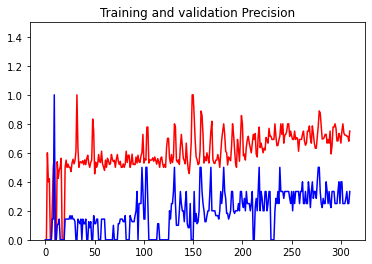

<Figure size 432x288 with 0 Axes>

In [ ]:
precision = history.history['precision']
val_precision = history.history['val_precision']
epochs=range(len(precision))
plt.plot(epochs, precision, 'r')
plt.plot(epochs, val_precision, 'b')
plt.title('Training and validation Precision')
plt.ylim((0,1.5))
plt.figure()

In [ ]:
model_mac_precision.evaluate(X_test_us, clf_test_us)

2/2 [==============================] - 0s 8ms/step - loss: 0.2499 - precision: 0.7500


[0.24986295402050018, 0.75]

# **2.  Richer Text**

Our main dataset consists of short and concise statements which indicate the final considerations for the policy choice.  Most researchers, however, have used the much more extensive meeting minutes.  These may give a better window into the uncertainty, optimism and pessimism of the monetary policy committee.  

On the other hand, these long statements may difficult for models that do not use transformers, such as our LSTM model.

To determine the impact, we ran the richer text data on our simple LSTM and compared it to the original results.  

In [ ]:
#Statistics
approx_length = df_train_us['minutes'].str.split(" ").str.len()
approx_length.describe()

count      98.000000
mean     2550.163265
std       765.612519
min        89.000000
25%      2147.750000
50%      2992.500000
75%      3033.750000
max      3131.000000
Name: minutes, dtype: float64

## Prepare data for embeddings
We must drop the na values for minutes and create the padded sequences.


In [ ]:
df_train_us=df_train_us.dropna()
df_val_us=df_val_us.dropna()
df_test_us=df_test_us.dropna()

#check
df_train_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 100
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   level_0                 98 non-null     int64  
 1   index                   98 non-null     int64  
 2   bank                    98 non-null     object 
 3   filename                98 non-null     object 
 4   date_dt                 98 non-null     object 
 5   chron_order_in_country  98 non-null     int64  
 6   rate_curr               98 non-null     float64
 7   rate_next               98 non-null     float64
 8   rate_change             98 non-null     int64  
 9   urate                   98 non-null     float64
 10  inf                     98 non-null     float64
 11  eff_rate                98 non-null     float64
 12  statement               98 non-null     object 
 13  text_include            98 non-null     int64  
 14  nairu                   98 non-null     flo

In [ ]:
#We will also need to reset the y values and labels
y_train_us=np.array(df_train_us.rate_next)
y_test_us=np.array(df_test_us.rate_next)
y_val_us=np.array(df_val_us.rate_next)

In [ ]:
def prep_text(texttrain, textval, texttest):
  tr_sentences=np.array(texttrain)
  val_sentences=np.array(textval)
  test_sentences=np.array(texttest)
  return tr_sentences, val_sentences, test_sentences

In [ ]:
#Convert minutes to numpy arrays - US
training_sentences_us, val_sentences_us, testing_sentences_us = prep_text(df_train_us.minutes,\
                                                                          df_val_us.minutes,\
                                                                          df_test_us.minutes)

In [ ]:
#Convert rename 
# Continuous target variable
training_labels_final_us, val_labels_final_us, test_labels_final_us = prep_text(y_train_us, y_val_us, y_test_us)

print(training_labels_final_us.shape, val_labels_final_us.shape, test_labels_final_us.shape)

(98,) (32,) (32,)


In [ ]:
#Create embeddings based on the corpus

max_length = 3000 #Number of tokens per statement 
trunc_type = 'post'
padding_type = 'post'

vocab_size = 6000 
oov_tok = '<OOV>' 
embedding_dim = 16 

In [ ]:
#Apply tokenizer which translates words into numbers
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences_us)
word_index = tokenizer.word_index

In [ ]:
#Find the indexes for words we could not find before.
check_list=['staff','housing', 'macroeconomic', 'war']
      
[word_index[i] for i in check_list]

[57, 104, 1388, 4127]

In [ ]:
len(word_index) #there are a lot more words - almost 5 times more

5940

In [ ]:
#pad sequences
sequences_us = tokenizer.texts_to_sequences(training_sentences_us)
padded_us = pad_sequences(sequences_us, maxlen=max_length, truncating=trunc_type)

val_sequences_us = tokenizer.texts_to_sequences(val_sentences_us)
val_padded_us = pad_sequences(val_sequences_us, maxlen=max_length)

test_sequences_us = tokenizer.texts_to_sequences(testing_sentences_us)
test_padded_us = pad_sequences(test_sequences_us, maxlen=max_length)

Let's take a look at these sequences arrays.

In [ ]:
print(padded_us.shape, val_padded_us.shape, test_padded_us.shape)

(98, 3000) (32, 3000) (32, 3000)


In [ ]:
padded_us

array([[ 135,    5,  155, ...,  648,  269,   59],
       [   0,    0,    0, ...,  567,  629,  577],
       [ 135,    5,  155, ...,   52,  187,   26],
       ...,
       [   0,    0,    0, ...,    4,  636, 5907],
       [ 135,    5,  155, ...,  774,  212,  140],
       [   0,   13,  180, ...,   21,   67, 5940]], dtype=int32)

### A simple LSTM.  

Previously, the test rmse was .52.  With the new data, it was about .8 - much worse.  We also tried doubling the size of the embedding dimensions to accomodate a richer dataset, which did not help. Overall, this model trained very well but was over-fit to the data and did poorly in both sample and validation tests.  It is likey that a different tool was needed for the job of analyzing these long texts.

In [ ]:
#Now run the model!
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(embedding_dim),
    tf.keras.layers.Dense(480,activation='relu'),
    tf.keras.layers.Dense(464,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model_lstm.compile(loss='mse', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
num_epochs = 2500
early_stop = EarlyStopping(monitor='val_root_mean_squared_error', 
                           mode='min', patience=300, verbose=False)
history = model_lstm.fit(padded_us, y_train_us, 
                    epochs=num_epochs, verbose=False, callbacks=[early_stop],
                    validation_data=(val_padded_us, y_val_us))

<Figure size 432x288 with 0 Axes>

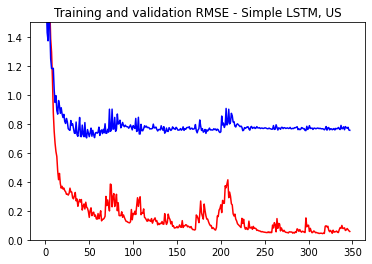

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
epochs=range(len(rmse))
plt.plot(epochs, rmse, 'r')
plt.plot(epochs, val_rmse, 'b')
plt.title('Training and validation RMSE - Simple LSTM, US')
plt.ylim((0,1.5))
plt.figure()

In [ ]:
model_lstm_eval=model_lstm.evaluate(test_padded_us, y_test_us)
model_lstm_eval 

1/1 [==============================] - 0s 77ms/step - loss: 0.6896 - root_mean_squared_error: 0.8304


[0.6896129250526428, 0.8304293155670166]

# **3.  Text augmentation with noise**

Result: Test rmse ~.8, higher than original data.

We used the Text Attack package to make small perturbations to the post-meeting (shorter) statements.  

According to research, noise can force an nlp model to train over a wider range of inputs, increasing its robustness and test performance.  Furthermore the perturbed texts can be appended to the training dataset, increasing its size.  

The package offers several augmentation tools and we chose the WordNet Augmenter.  This tool replaces random words in each sample with related in WordNet.  Sometimes it gets teh sense of the word right, other times it substitutes a word that is synonymous only in a sense not used in the text (e.g., "energy prices" becomes "vigor prices").

**The textattack package takes a long time to run even on a small number of samples (we managed 20) and premium GPU.** 

For this reason we are going to show the code we used to generate the text and read in the data, rather than running the code from this notebook.

Reference: https://towardsdatascience.com/text-data-augmentation-f4143571ecd2

In [ ]:
#Do not run this code block 

## Set up
#! pip install textattack
#import textattack
#from textattack.augmentation import WordNetAugmenter

## Indicate the original datas is not augmented.
#df_train_us['text_aug']="no"

##Given the time reqiured to run even one sample,choose 20 relatively short ones.
#include=[0,1,3,7,10,14,16,20,21,22,23,26,29,30,35,36,38,39,43,65]

## Create the dataset that will be augemented
#train_aug = df_train_us.iloc[include, :] 

## Specify parameters
#aug = WordNetAugmenter(pct_words_to_swap = 0.1, transformations_per_example = 1,
                      #fast_augment=True)

## Augment
#train_aug['statement'] = train_aug['statement'].apply(lambda x: str(aug.augment(x)))

##Indicate new data is augmented.
#train_aug['text_aug']=train_aug.text_aug.str.replace('no','yes')

##Add new samples to training data
#df_train_us=df_train_us.append(train_aug)

Now that we have some augmented training data we can read it in.  The file includes BOTH the 20 augmented samples and their original counterparts, bringing up the number of observations from 101 to 121.

The test and validation sets are unchanged. 

In [ ]:
# Now that we have created some augmented text let's read it in.
# 
df_train_us=pd.read_excel('/content/df_train_us_with_aug2.xlsx')

In [ ]:
df_train_us.shape

(121, 13)

In [ ]:
#Examples of perturbed text
df_train_us.loc[111,'statement']

"indicates proletariat mart remains warm economic activity uprise moderate rate. job gains solid average recent months unemployment rate remained low. although growth household spending piece earlier year growth business fixed investment soft. month basis overall inflation inflation items food energy range. market based measures inflation compensation remain grim; survey based measures longer term inflation expectations little changed. consistent statutory mandate committee seeks foster maximum employment price stability. light implications global developments economic outlook well muted inflation pressures committee decided lower target range federal funds rate. action supports committee's view sustained expansion economic activity strong labor market term inflation near committee's symmetric   objective likely outcomes uncertainties outlook remain. committee contemplates future path target tramp federal funds rate preserve monitor implications incoming information economic outlook ac

In [ ]:
#Original version
df_train_us.loc[112,'statement']

"indicates labor market remains strong economic activity rising moderate rate. job gains solid average recent months unemployment rate remained low. although growth household spending picked earlier year growth business fixed investment soft. month basis overall inflation inflation items food energy running. market based measures inflation compensation remain low; survey based measures longer term inflation expectations little changed. consistent statutory mandate committee seeks foster maximum employment price stability. light implications global developments economic outlook well muted inflation pressures committee decided lower target range federal funds rate. action supports committee's view sustained expansion economic activity strong labor market conditions inflation near committee's symmetric   objective likely outcomes uncertainties outlook remain. committee contemplates future path target range federal funds rate continue monitor implications incoming information economic outl

Perturbed sentence: indicates proletariat mart remains warm economic activity uprise moderate rate.

Original:  indicates labor market remains strong economic activity rising moderate rate.

In [ ]:
#Now feed the new data into our functions for formatting.  

#We will also need to reset the y values and labels since we have more cases.
y_train_us=np.array(df_train_us.rate_next)
#confirm new shape

y_train_us.shape

(121,)

In [ ]:
#In the prior excursion we looked at the (long) minutes; 
#change text to 'statements'
training_sentences_us, val_sentences_us, testing_sentences_us = prep_text(df_train_us.statement,\
                                                                          df_val_us.statement,\
                                                                          df_test_us.statement)

In [ ]:
#Ensure all the target variables are in the right format and shape
training_labels_final_us, val_labels_final_us, test_labels_final_us = prep_text(y_train_us, y_val_us, y_test_us)


In [ ]:
print(training_labels_final_us.shape,val_labels_final_us.shape,test_labels_final_us.shape)

(121,) (32,) (32,)


In [ ]:
#Create new embeddings based on the corpus

max_length = 1200 #Number of tokens per statement 
trunc_type = 'post'
padding_type = 'post'

vocab_size = 1400
oov_tok = '<OOV>' 
embedding_dim = 16 

In [ ]:
#Apply tokenizer which translates words into numbers
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences_us)
word_index = tokenizer.word_index

In [ ]:
#Find the indexes for some new words
check_list=['mart','drudge', 'mate', 'proletariat','pet']
      
[word_index[i] for i in check_list]

[1343, 858, 980, 1342, 1353]

In [ ]:
len(word_index) #About 200 more words than in the original vocab

1370

In [ ]:
#pad sequences
sequences_us = tokenizer.texts_to_sequences(training_sentences_us)
padded_us = pad_sequences(sequences_us, maxlen=max_length, truncating=trunc_type)

val_sequences_us = tokenizer.texts_to_sequences(val_sentences_us)
val_padded_us = pad_sequences(val_sequences_us, maxlen=max_length)

test_sequences_us = tokenizer.texts_to_sequences(testing_sentences_us)
test_padded_us = pad_sequences(test_sequences_us, maxlen=max_length)

In [ ]:
#Now run the model!
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(embedding_dim),
    tf.keras.layers.Dense(480,activation='relu'),
    tf.keras.layers.Dense(464,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model_lstm.compile(loss='mse', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
num_epochs = 2500
early_stop = EarlyStopping(monitor='val_root_mean_squared_error', 
                           mode='min', patience=300, verbose=False)
history = model_lstm.fit(padded_us, y_train_us, 
                    epochs=num_epochs, verbose=False, callbacks=[early_stop],
                    validation_data=(val_padded_us, y_val_us))

<Figure size 432x288 with 0 Axes>

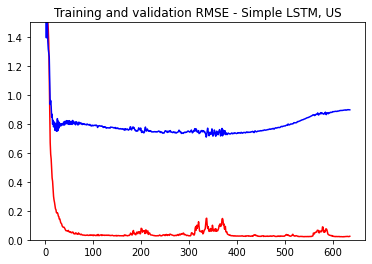

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
epochs=range(len(rmse))
plt.plot(epochs, rmse, 'r')
plt.plot(epochs, val_rmse, 'b')
plt.title('Training and validation RMSE - Simple LSTM, US, Perturbed')
plt.ylim((0,1.5))
plt.figure()

In [ ]:
model_lstm_eval=model_lstm.evaluate(test_padded_us, y_test_us)
model_lstm_eval 

1/1 [==============================] - 0s 44ms/step - loss: 0.5468 - root_mean_squared_error: 0.7395


[0.5468456745147705, 0.7394901514053345]